# Ripple NRTidal verification notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from ripple.waveforms import IMRPhenomD
import matplotlib.pyplot as plt
from ripple import ms_to_Mc_eta
from ripple.constants import MSUN, gt
from jax import grad, vmap
from functools import partial
# import importlib
# import tqdm

%load_ext autoreload
%autoreload 2
from ripple.waveforms import X_NRTidalv2

# To get plot style
import requests
script_url = "https://raw.githubusercontent.com/ThibeauWouters/cheat_sheets/main/myploystyle.py"
exec(requests.get(script_url).text)

jax.config.update("jax_enable_x64", True) # improve precision for comparing waveforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will compare waveforms with the following intrinsic parameters, which are close to the extremes on which the LAL implementation has been reviewed:

In [2]:
m1 = 3 # masses
m2 = 3

chi1 = 0.0 # spins
chi2 = 0.0

lambda1 = 400 # tidal deformabilities
lambda2 = 400

distance = 1.

Get the frequency grid:

In [3]:
# Frequency grid
T = 16
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
# df = freqs[1] - freqs[0]
df = 0.01
fs = freqs[(freqs > f_l) & (freqs < f_u)]

## Ripple

In [4]:
m1_msun = m1
m2_msun = m2
chi1 = chi1
chi2 = chi2
tc = 0
phic = 0
dist_mpc = distance
inclination = 0.0
polarization_angle = 0.0

Mc, eta = ms_to_Mc_eta(jnp.array([m1_msun, m2_msun]))

theta_ripple = jnp.array([Mc, eta, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

# And finally lets generate the waveform!
hp_ripple, hc_ripple = X_NRTidalv2.gen_NRTidalv2_hphc(fs_ripple, theta_ripple, f_ref)

[2.61165169 0.25       0.         0.         1.         0.
 0.        ]
Kappa
75.0
Tidal amplitude
[-1.08335243e-30 -1.08452784e-30 -1.08570393e-30 ... -1.59961454e-25
 -1.59962444e-25 -1.59963434e-25]
quadparam
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
octparam
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
quadparam
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
octparam
Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=1/0)>
Psi tidal
[-4.85926860e-05 -4.86332173e-05 -4.86737621e-05 ... -3.81403528e-01
 -3.81405148e-01 -3.81406769e-01]
Psi SS
[0. 0. 0. ... 0. 0. 0.]


In [5]:
# test_low = X_NRTidalv2._compute_quadparam_octparam(0)
# test_high = X_NRTidalv2._compute_quadparam_octparam(350)

# print(test_low)
# print(test_high)

## Bilby

Check the LAL code (and also how to compute the mismatch between your waveform and LAL) in [this tutorial](https://github.com/tedwards2412/ripple/blob/main/test/check_waveform_match.py).

In [6]:
# import lalsimulation as lalsim
# import lal

import bilby

In [7]:
injection_parameters = dict(
    mass_1 = m1,
    mass_2 = m2,
    chi_1 = chi1,
    chi_2 = chi2,
    luminosity_distance = distance,
    theta_jn = 0,
    psi = 0,
    phase = 0,
    geocent_time = 0,
    ra = 0,
    dec = 0,
    lambda_1 = lambda1,
    lambda_2 = lambda2,
)


In [9]:
# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomD_NRTidalv2",
    reference_frequency=f_ref,
    minimum_frequency=f_l,
)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=T,
    sampling_frequency=f_sampling,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)

strain = waveform_generator.frequency_domain_strain()


20:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


AttributeError: 'WaveformGenerator' object has no attribute '_WaveformGenerator__parameters'

In [31]:
IMRphenom = "IMRPhenomD_NRTidalv2"
IMRphenom = "IMRPhenomD_NRTidal"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

f_ASD, ASD = np.loadtxt("../test/O3Livingston.txt", unpack=True)

theta = np.array([m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination])

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    lambda1,
    lambda2,
    df,
    f_l,
    f_u,
    f_ref,
    None,
    approximant,
)
freqs_lal = np.arange(len(hp.data.data)) * df

# Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))

# theta_ripple = np.array(
#     [Mc, eta, theta[2], theta[3], dist_mpc, tc, phic, inclination]
# )
# hp_ripple = waveform(theta_ripple)
pad_low, pad_high = get_eff_pads(fs)
PSD_vals = np.interp(fs, f_ASD, ASD) ** 2

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]

Quick test:

## Comparison

In [32]:
# One frequency variable, just f
f = fs_ripple

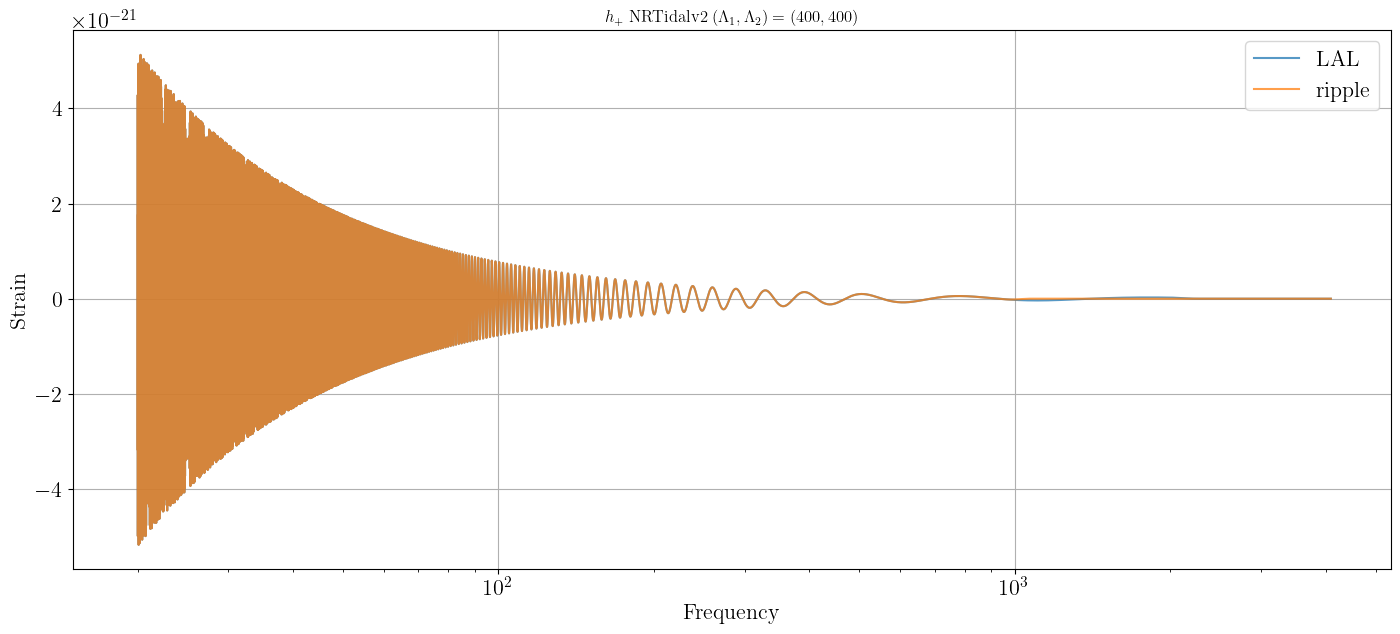

In [33]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label = "LAL", alpha = a)
plt.plot(f, hp_ripple.real, "-", label = "ripple", alpha = a)
plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.legend()
plt.show()

In [34]:
# plt.subplots(1, 1, figsize=(17, 7))
# diffs = abs(hp_lalsuite.real - hp_ripple.real) 
# plt.plot(f, diffs, "-", label = "Differences", color="black")
# plt.title(f"h+, NRTidalv2 lambda1, lambda2 = {lambda1, lambda2}")
# plt.title(r"$h_+$ NRTidalv2 ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(lambda1, lambda2))
# plt.xlabel("Frequency")
# plt.ylabel("Strain")
# plt.xscale('log')
# plt.yscale('log')
# plt.xlim(f_l - 5)
# plt.legend()
# plt.show()

My kappa: 75.0
Frequency merger:  917.0453749351901
Frequency merger LAL 1931.2106210815027
Lal kappa: 0.0


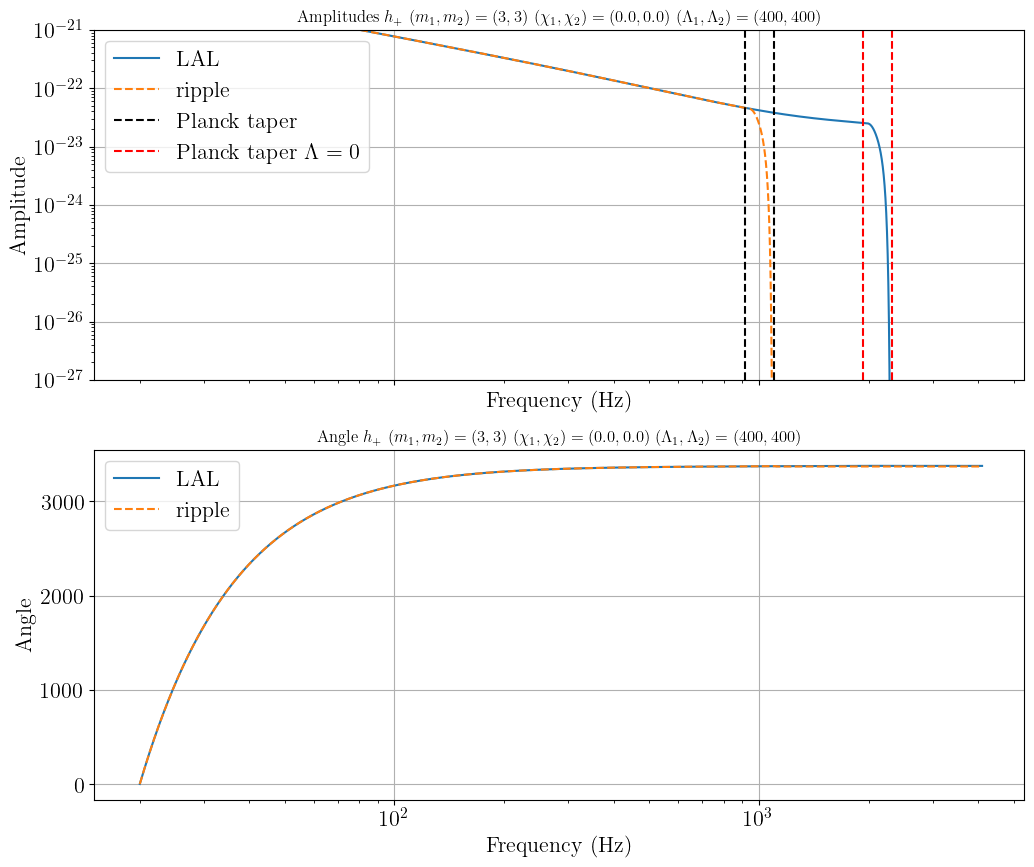

In [47]:
## Get the merger frequency to check the Planck taper window

# l1, l2 = lambda1 / ((m1 * MSUN)**5), lambda2 / ((m2 * MSUN)**5)
l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])
print(f"My kappa: {X_NRTidalv2.get_kappa(merger_params)}")

f_merger = X_NRTidalv2._get_merger_frequency(merger_params)
f_merger = float(f_merger)

l1, l2 = 0, 0
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

# print("Merger params (m1, m2, chi1, chi2, lambda1, lambda2): ", merger_params)
print("Frequency merger: ", f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label = "LAL")
plt.plot(fs_ripple, A_ripple, "--", label = "ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')


lal_kappa = lalsim.SimNRTunedTidesComputeKappa2T(m1, m2, l1, l2)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), lal_kappa, m1/m2)
print(f"Frequency merger LAL {lal_f_merger}")

# Kappas
print(f"Lal kappa: {lal_kappa}")


plt.axvline(lal_f_merger, linestyle = "--", color = 'red', label = r'Planck taper $\Lambda = 0$')
plt.axvline(1.2 * lal_f_merger, linestyle = "--", color = 'red')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label = "ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label = "LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label = "ripple")
    name = "Phase"
plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.show()

**Discussion:** Again, we see that at high frequencies, there is a mismatch. For the amplitude, this could be solved by the Planck taper. However, the tapering window that I find (see dashed black lines) will not fix this issue. For the phase/angle: this is likely solved by adding the contribution from the spin-spin interaction, which is currently giving wrong results (one has to double check the implementation in the source code).

**Note:** There is a small difference in step size of the frequency grid between the one employed by LAL and the one used by ripple (not sure why). This is, however, only a small change in the final frequency, so negligible. Also checked with doing an interpolation of frequency grids: this does not affect the errors reported below.

In [36]:
df_ripple = fs_ripple[1] - fs_ripple[0]
df_lal = freqs_lal[1] - freqs_lal[0]

print(df_ripple)
print(df_lal)

print(fs_ripple[-1])
print(freqs_lal[mask_lal][-1])
print(abs(freqs_lal[mask_lal][-1] - fs_ripple[-1]))

0.010000000000001563
0.01
4095.9900000006373
4095.9900000000002
6.371010385919362e-10


In [37]:
correct_freqs = True # correct frequency grid by interpolation
if correct_freqs:
    A_lalsuite = jnp.interp(f, freqs_lal[mask_lal], A_lalsuite)
    angle_lalsuite = jnp.interp(f, freqs_lal[mask_lal], angle_lalsuite)

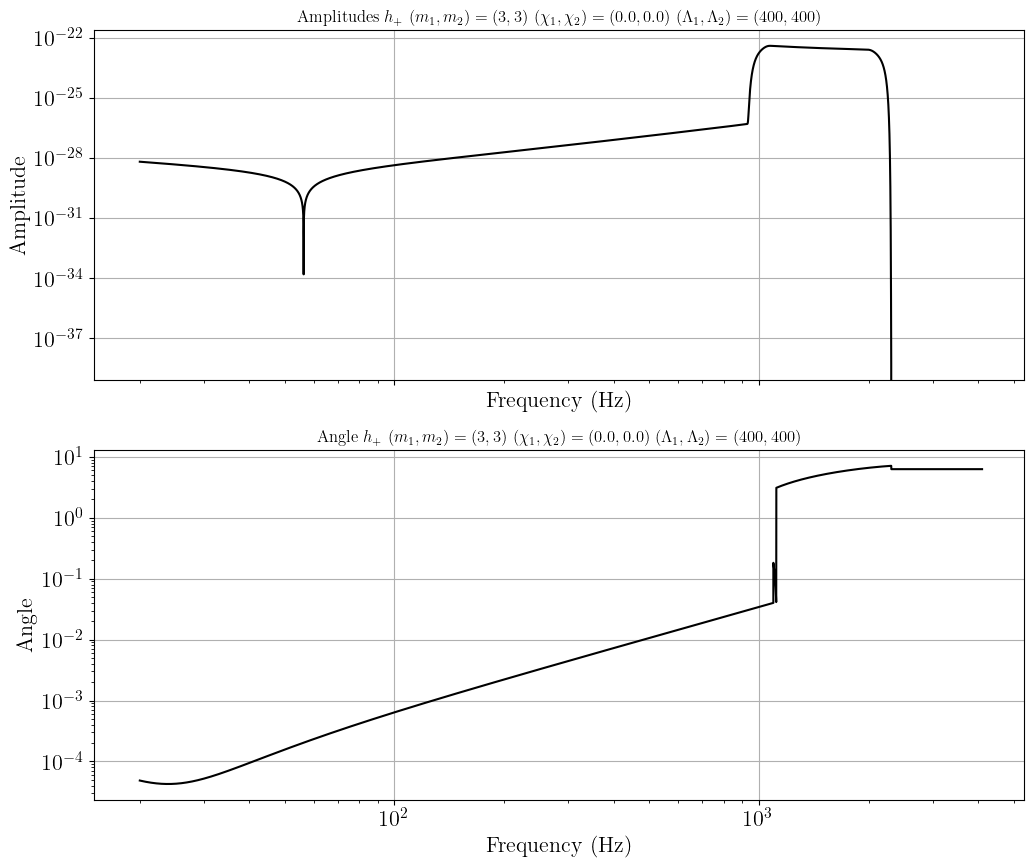

In [38]:
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

# Plot where the Planck taper has to take place
# plt.axvline(f_merger, linestyle = "--", color = 'black', label = 'Planck taper')
# plt.axvline(1.2 * f_merger, linestyle = "--", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.yscale('log')
plt.show()

**Discussion:** Same remarks as above. For the angle, the spin-spin contributions could solve the increasing error in the second plot. For the amplitude: I am a bit surprised that the error in amplitude seems to be increasing with increasing frequency and I am not sure what is causing this. This will not be fixed by the Planck taper. Is there another bug in the implementation? 

# Debugging

### Kappa and merger frequency?

In [39]:
lal_kappa = lalsim.SimNRTunedTidesComputeKappa2T(m1 * MSUN, m2* MSUN, lambda1, lambda2)
print(lal_kappa)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), lal_kappa, m1/m2)
print(lal_f_merger)
lal_f_merger = lalsim.SimNRTunedTidesMergerFrequency((m1 + m2), 5000, m1/m2)
print(lal_f_merger)

75.0
917.0453894393181
403.5843715677725


### Amplitude error grows?

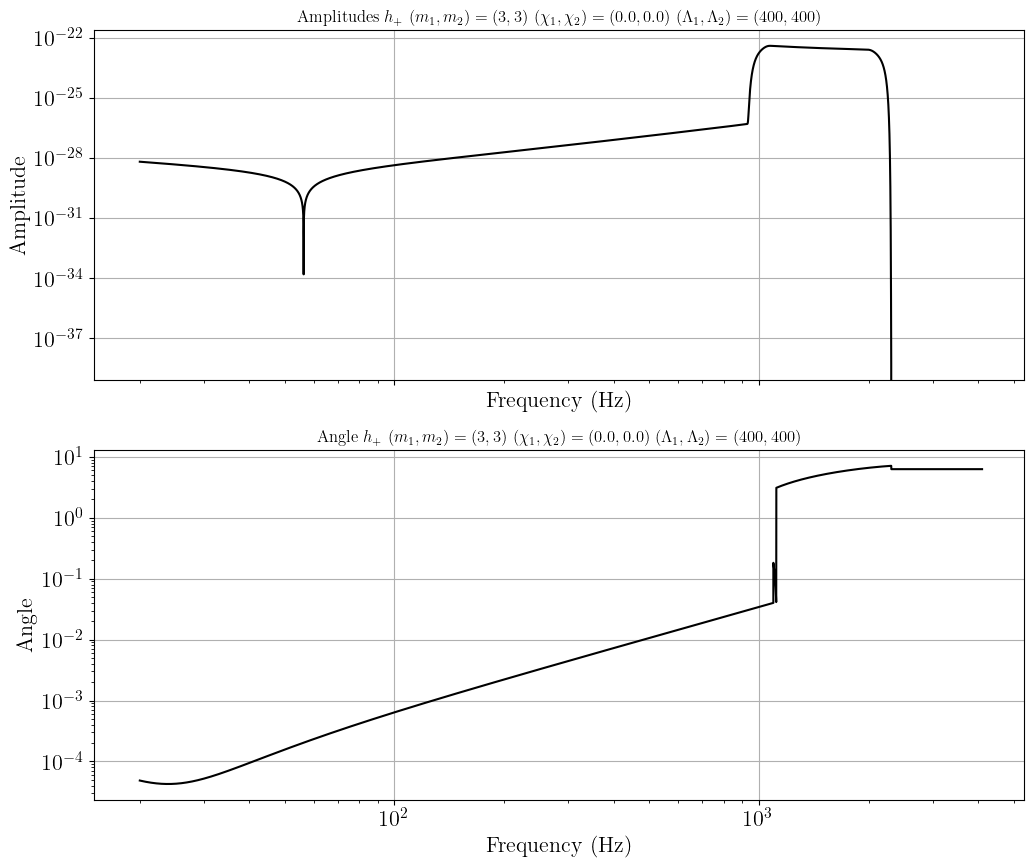

In [40]:
# Choose two points
idx1, idx2 = round(0.2 * len(f)), round(0.5 * len(f))

# Plot them for visualization
plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
diffs_amplitude = abs(A_lalsuite - A_ripple)
plt.plot(f, diffs_amplitude, "-", color = 'black')

plt.title(r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(m1, m2, chi1, chi2, lambda1, lambda2))
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
# plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
# plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)

plt.plot(f, abs(angle_lalsuite - angle_ripple), "-", color = 'black')
name = "Angle"
# plt.legend()
plt.title(r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(name, m1, m2, chi1, chi2, lambda1, lambda2))
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale('log')
plt.xlim(f_l - 5)
plt.yscale('log')
plt.show()

Get the slope

In [41]:
slope = (np.log(diffs_amplitude[idx2]) - np.log(diffs_amplitude[idx1])) / (np.log(f[idx2]) - np.log(f[idx1]))
slope

9.51963953190807

### Tidal corrections phase

In [42]:
psi_SS = X_NRTidalv2.get_spin_phase_correction(fs_ripple, jnp.array([m1, m2, chi1, chi2, lambda1, lambda2]))


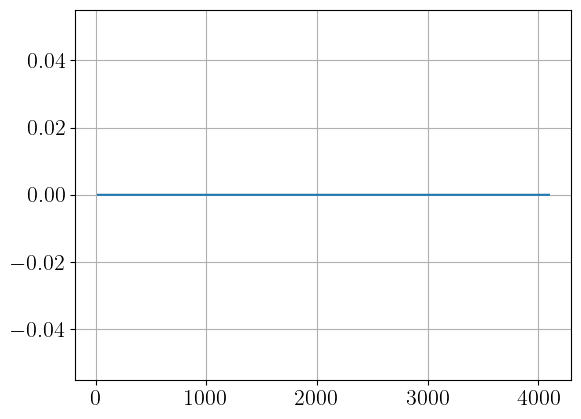

In [43]:
plt.plot(fs_ripple, psi_SS)
plt.show()

### Get tidal amplitude

In [44]:
ampT = np.empty_like(f)
test = lalsim.SimNRTunedTidesFDTidalAmplitudeFrequencySeries(ampT, f, m1, m2, lambda1, lambda2)
test

0

In [45]:
ampT

array([-8.78796054e-04, -8.79775015e-04, -8.80754591e-04, ...,
       -3.19875095e+01, -3.19876202e+01, -3.19877309e+01])